In [59]:
import numpy as np
from qutip import Options
import qutip as qt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitCavity
from quantum_logical.pulsesim.mode import QubitMode, CavityMode
import matplotlib.pyplot as plt

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [60]:
# Optionally, can build from a YAML file instead :)
# quantum_system = QuantumSystem.from_yaml(yaml_file)

# TODO
# FIXME, these kwargs attributes are ugly/bad :(
qubit1 = QubitMode(mode_type="Qubit", name="q1", dim=2, freq=3.0, alpha=-0.1)
qubit2 = QubitMode(mode_type="Qubit", name="q2", dim=2, freq=3.0, alpha=-0.1)
cavity = CavityMode(mode_type="Cavity", name="c", dim=10, freq=5.0)
_couplings = {(qubit1, cavity): 2 * np.pi * 0.01, (qubit2, cavity): 2 * np.pi * 0.01}

quantum_system = QuantumSystem([qubit1, qubit2, cavity], couplings=_couplings)

In [61]:
hamiltonian = QubitQubitCavity(quantum_system)
# hamiltonian.H + sum(hamiltonian._H_int())  # full hamiltonian
hamiltonian.H  # non-interacting hamiltonian

Quantum object: dims = [[2, 2, 10], [2, 2, 10]], shape = (40, 40), type = oper, isherm = True
Qobj data =
[[-18.84955592   0.           0.         ...   0.           0.
    0.        ]
 [  0.          12.56637061   0.         ...   0.           0.
    0.        ]
 [  0.           0.          43.98229715 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 238.76104167   0.
    0.        ]
 [  0.           0.           0.         ...   0.         270.17696821
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  301.59289474]]

In [62]:
# prepare an initial state
psi0 = quantum_system.prepare_tensor_fock_state([(qubit1, 1)])

# prepare qubit bell state tensored with cavity in vacuum state
# psi0 = qt.tensor(qt.bell_state("01"), qt.basis(cavity.dim, 0))

# prepare an inital state |01> for qubits and a slight excitation in the cavity
# |cavity> = .99 |0> + .1 |1>
# psi0 = qt.tensor(
#     qt.basis(qubit1.dim, 0),
#     qt.basis(qubit2.dim, 1),
#     0.99 * qt.basis(cavity.dim, 0) + 0.1 * qt.basis(cavity.dim, 1),
# )

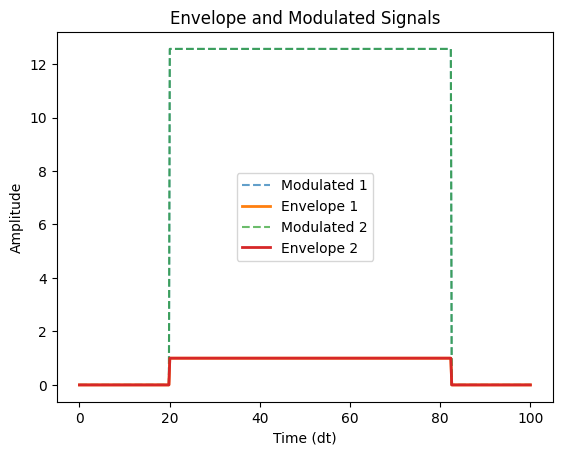

In [63]:
width_d1 = 5 * np.pi / (4 * quantum_system.couplings[(qubit1, cavity)])
# width_d2 = 2 * np.pi / (4 * quantum_system.couplings[(qubit2, cavity)])

args1 = {"shape": Pulse.box, "shape_params": {"t0": 20, "width": width_d1}}
pulse1 = Pulse(omega=0.0, amp=np.abs(qubit1.freq - cavity.freq))
lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731

args2 = {"shape": Pulse.box, "shape_params": {"t0": 20, "width": width_d1}}
pulse2 = Pulse(omega=0.0, amp=np.abs(qubit2.freq - cavity.freq))
lambda_pulse2 = lambda t, args: pulse2.drive(t, args2)  # noqa: E731

# plot an example pulse from the experiment to verify its shape
t_list = np.linspace(0, 100, 500)
Pulse.plot_pulse([(pulse1, args1), (pulse2, args2)], t_list)

In [64]:
# Define experiment constants
N = 50  # Number of points in the parameter sweep
width_range = np.linspace(0, t_list[-1], N)  # Sweep pulse width
amp_range = np.linspace(0, 30, N)  # Sweep pulse amplitude


def simulation_task(width_amp_tuple):
    width, amp = width_amp_tuple
    # XXX For now, assuming same pulse for both qubits
    args1["shape_params"]["width"] = width
    pulse1.amp = amp
    lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731
    H = hamiltonian.driven(lambda_pulse1, lambda_pulse1)
    solve_result = qt.mesolve(H, psi0, t_list, options=opts)
    final_state = solve_result.states[-1]
    ground_state_populations = [
        quantum_system.mode_population_expectation(final_state, mode, 0)
        for mode in quantum_system.modes
    ]
    return ground_state_populations


# Prepare the parameters for parallel execution
width_amp_pairs = [(w, a) for w in width_range for a in amp_range]

# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, width_amp_pairs, progress_bar=True)

# Process results
ground_state_populations = np.zeros(
    (len(quantum_system.modes), len(amp_range), len(width_range))
)
for idx, (width, amp) in enumerate(width_amp_pairs):
    width_idx = np.where(width_range == width)[0][0]
    amp_idx = np.where(amp_range == amp)[0][0]
    populations = results[idx]
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp_idx, width_idx] = pop

10.0%. Run time:   3.09s. Est. time left: 00:00:00:27
20.0%. Run time:   6.34s. Est. time left: 00:00:00:25
30.0%. Run time:   9.73s. Est. time left: 00:00:00:22
40.0%. Run time:  13.50s. Est. time left: 00:00:00:20
50.0%. Run time:  17.88s. Est. time left: 00:00:00:17
60.0%. Run time:  22.98s. Est. time left: 00:00:00:15
70.0%. Run time:  28.49s. Est. time left: 00:00:00:12
80.0%. Run time:  34.69s. Est. time left: 00:00:00:08
90.0%. Run time:  40.84s. Est. time left: 00:00:00:04
100.0%. Run time:  46.40s. Est. time left: 00:00:00:00
Total run time:  46.42s


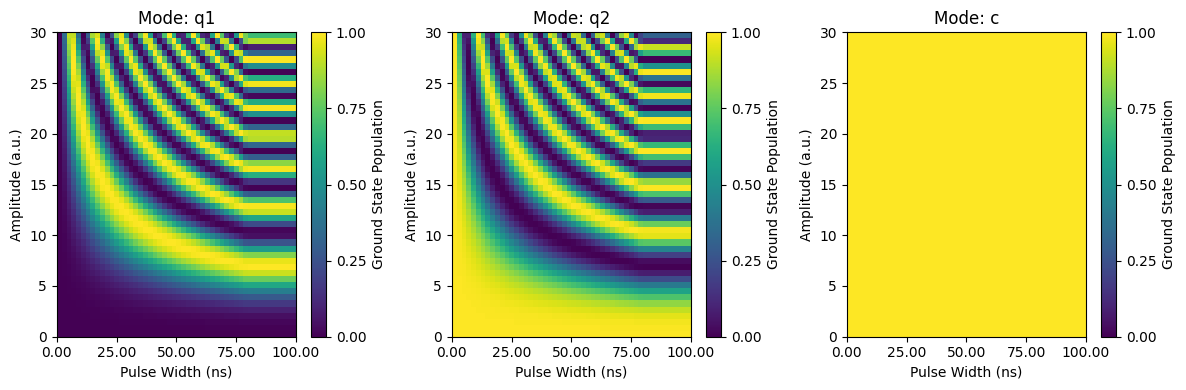

In [65]:
# Prepare the plot
fig, axes = plt.subplots(
    1, len(quantum_system.modes), figsize=(len(quantum_system.modes) * 4, 4)
)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# Plot data for each mode
for k, mode in enumerate(quantum_system.modes):
    im = axes[k].imshow(
        ground_state_populations[k],
        extent=[width_range[0], width_range[-1], amp_range[0], amp_range[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,  # Set color bar scale from 0.0 to 1.0
    )
    axes[k].set_title(f"Mode: {mode.name}")
    axes[k].set_xlabel("Pulse Width (ns)")
    axes[k].set_ylabel("Amplitude (a.u.)")

    # Customize x-axis ticks
    # xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
    xticks = np.linspace(width_range[0], width_range[-1], n_xticks)
    axes[k].set_xticks(xticks)
    axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

    # Add color bar
    cbar = fig.colorbar(
        im, ax=axes[k], orientation="vertical", label="Ground State Population"
    )
    cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

plt.tight_layout()
plt.show()

In [70]:
# find the frequency and amplitude that maximized population in q1_mode
# this will be our calibrated iSWAP frequency and amplitude
max_pop = np.max(ground_state_populations[0])
max_pop_idx = np.where(ground_state_populations[0] == max_pop)
max_pop_width = width_range[max_pop_idx[1][0]]
max_pop_amp = amp_range[max_pop_idx[0][0]]
print(f"Max population: {max_pop:.2f}")
print(f"Max population width: {max_pop_width:.2f}")
print(f"Max population amplitude: {max_pop_amp:.2f}")

Max population: 1.00
Max population width: 71.43
Max population amplitude: 7.35


In [71]:
# set the calibrated width and amplitude
args1["shape_params"]["width"] = max_pop_width
pulse1.amp = max_pop_amp
lambda_pulse1 = lambda t, args: pulse1.drive(t, args1)  # noqa: E731
H = hamiltonian.driven(lambda_pulse1, lambda_pulse1)

e_ops = e_ops = [quantum_system.modes_num[m] for m in quantum_system.modes]
solve_result = qt.mesolve(
    H,
    psi0,
    t_list,
    e_ops=e_ops,
    progress_bar=p_bar,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.04s. Est. time left: 00:00:00:00


50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.07s. Est. time left: 00:00:00:00
70.0%. Run time:   0.08s. Est. time left: 00:00:00:00
80.0%. Run time:   0.10s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.13s


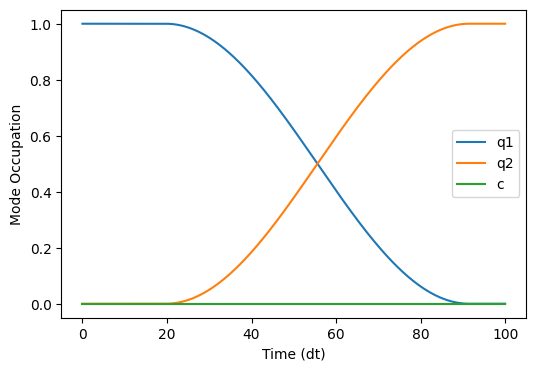

In [72]:
# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(quantum_system.modes):
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (dt)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()